----
# import libraries and data

In [1]:
import os
import sys
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    fbeta_score,
)

# import own modules
sys.path.append("..")  # Adds higher directory to python modules path.
from scripts import preprocessing as pp
from scripts import evaluate_models as em

# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle"
)

In [2]:
# path to csv file
path_df = os.path.join("..", "data", "df_deep_sam.csv")

# get features
df = pd.read_csv(path_df)

# set id as index
df = df.set_index("id", drop=True)

# drop first batch of useless variables
df = df.drop(columns=["img", "sp_idx"])
df = df.drop(columns=[col for col in df.columns if "_obj" in col])

# processing
df = df[df["sp_fix_duration_ms_total"] <= 5000]

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

# prepare features and target
X = df
y = X.pop("asd")

# define numerical columns once more
num_cols = X.columns[X.dtypes != "object"]

# train-test-split
X_train, X_test, y_train, y_test = pp.split(X, y)

# print info
print(f"train-set has '{len(y_train)}' samples & '{X.shape[1]}' features")
print(f"test-set has '{len(y_test)}' samples - out of '{df.shape[0]}'")
print(f"  ~ {len(y_test) / df.shape[0] * 100:.2f}% of full dataset")

 -> dataframe has 7217 instances and 44 columns
 -> there are 44 numerical columns
 -> there are 0 categoricals columns
train-set has '6485' samples & '43' features
test-set has '732' samples - out of '7217'
  ~ 10.14% of full dataset


----

# load models

In [3]:
with open(os.path.join("..", "models", "calibrated", "RF_calib.pickle"), "rb") as f:
    rf = pickle.load(f)

with open(os.path.join("..", "models", "calibrated", "XGB_calib.pickle"), "rb") as f:
    xgb = pickle.load(f)

with open(os.path.join("..", "models", "calibrated", "SVC_calib.pickle"), "rb") as f:
    svc = pickle.load(f)

with open(os.path.join("..", "models", "calibrated", "VTG_calib.pickle"), "rb") as f:
    vtg = pickle.load(f)

with open(
    os.path.join("..", "models", "calibrated", "stacking_LR_calib.pickle"), "rb"
) as f:
    sLR = pickle.load(f)

with open(
    os.path.join("..", "models", "calibrated", "stacking_NB_calib.pickle"), "rb"
) as f:
    sNB = pickle.load(f)

with open(
    os.path.join("..", "models", "calibrated", "stacking_GBM_calib.pickle"), "rb"
) as f:
    sGBM = pickle.load(f)

with open(
    os.path.join("..", "models", "calibrated", "stacking_KNN_calib.pickle"), "rb"
) as f:
    sKNN = pickle.load(f)

In [4]:
# 2. Generate predictions using the base models
svc_pred_train = svc.predict(X_train)
xgb_pred_train = xgb.predict(X_train)
rf_pred_train = rf.predict(X_train)

# 2. Generate predictions using the base models
svc_proba_train = svc.predict_proba(X_train)
xgb_proba_train = xgb.predict_proba(X_train)
rf_proba_train = rf.predict_proba(X_train)

# 2. Generate predictions using the base models
svc_pred_test = svc.predict(X_test)
xgb_pred_test = xgb.predict(X_test)
rf_pred_test = rf.predict(X_test)

# 2. Generate predictions using the base models
svc_proba_test = svc.predict_proba(X_test)
xgb_proba_test = xgb.predict_proba(X_test)
rf_proba_test = rf.predict_proba(X_test)

X_train_stacked = np.column_stack((svc_pred_train, xgb_pred_train, rf_pred_train))
X_test_stacked = np.column_stack((svc_pred_test, xgb_pred_test, rf_pred_test))

X_train_stacked_proba = np.column_stack(
    (svc_proba_train, xgb_proba_train, rf_proba_train)
)
X_test_stacked_proba = np.column_stack((svc_proba_test, xgb_proba_test, rf_proba_test))

----
# functions

In [5]:
def vary_threshold(clf, name, thresholds):
    proba_train = clf.predict_proba(X_train_stacked_proba)

    acc, prec, reca = [], [], []
    f1, f2, roc_auc = [], [], []

    cm_cmap = sns.light_palette("seagreen", as_cmap=True)
    nrows, ncols = 5, 7
    _, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 13))
    plt.suptitle(name)
    ax = ax.flatten()

    for i, thresh in enumerate(thresholds):
        y_pred = (proba_train[:, 1] > thresh) * 1

        roc_auc.append(roc_auc_score(y_true=y_train, y_score=proba_train[:, 1]))
        prec.append(precision_score(y_true=y_train, y_pred=y_pred))
        reca.append(recall_score(y_true=y_train, y_pred=y_pred))
        acc.append(accuracy_score(y_true=y_train, y_pred=y_pred))
        f1.append(f1_score(y_true=y_train, y_pred=y_pred))
        f2.append(fbeta_score(y_true=y_train, y_pred=y_pred, beta=2))

        iax = ax[i]
        plt.subplot(nrows, ncols, i + 1)
        sns.heatmap(
            confusion_matrix(y_train, y_pred),
            annot=True,
            cmap=cm_cmap,
            fmt="g",
            cbar=False,
        )
        plt.title(f"thresh. = {round(thresh,2)}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        iax.set_aspect("equal", "box")

    plt.tight_layout()

    # ------------------------------------------------------------
    df2 = pd.DataFrame({"thresh": thresholds})
    df2["acc"] = acc
    df2["prec"] = prec
    df2["reca"] = reca
    df2["f1"] = f1
    df2["f2"] = f2
    df2["roc_auc"] = roc_auc

    cols = ["acc", "prec", "reca", "f1", "f2", "roc_auc"]
    _, ax = plt.subplots(nrows=6, ncols=1, figsize=(12, 30))
    for i, c in enumerate(cols):
        plt.subplot(6, 1, i + 1)
        sns.barplot(data=df2, x="thresh", y=c)
        plt.title(c)
        plt.xlabel("threshold")
        plt.ylabel(c)
        plt.ylim(df2[c].min() - 0.01, df2[c].max() + 0.01)
    plt.tight_layout()

    #
    plt.figure()
    sns.lineplot(df2.set_index("thresh", drop=True))

In [6]:
def new_threshold(mdl, new_threshold=0.5):
    proba_train = mdl.predict_proba(X_train_stacked_proba)
    pred_train = (proba_train[:, 1] > new_threshold) * 1

    proba_test = mdl.predict_proba(X_test_stacked_proba)
    pred_test = (proba_test[:, 1] > new_threshold) * 1

    # evaluate model
    em.report(
        y_train=y_train,
        y_train_pred=pred_train,
        y_train_proba=proba_train,
        y_test=y_test,
        y_test_pred=pred_test,
        y_test_proba=proba_test,
    )

In [7]:
thresholds = [i / 100 for i in list(range(16, 86, 2))]

----

# KNN - calib

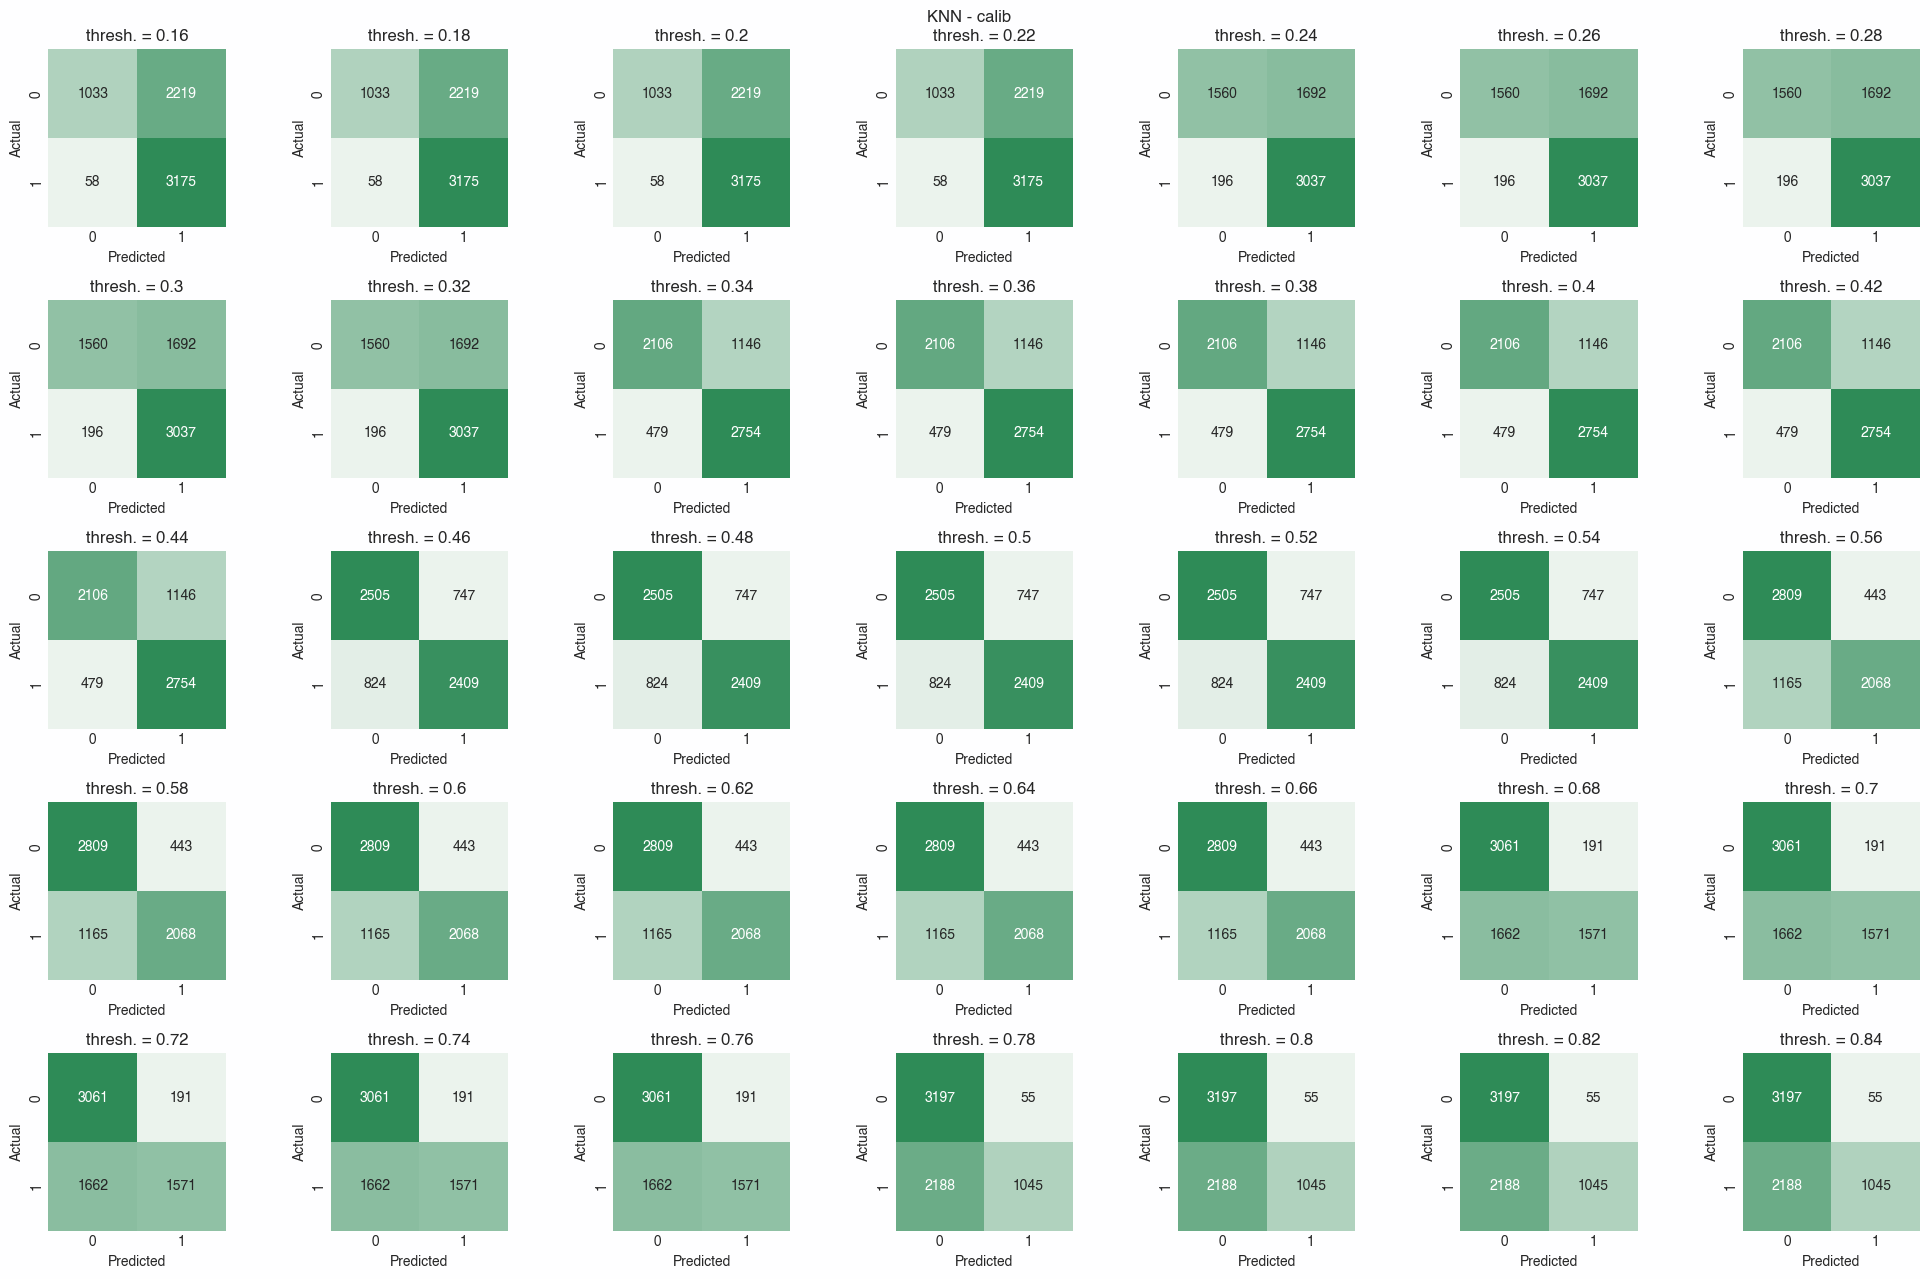

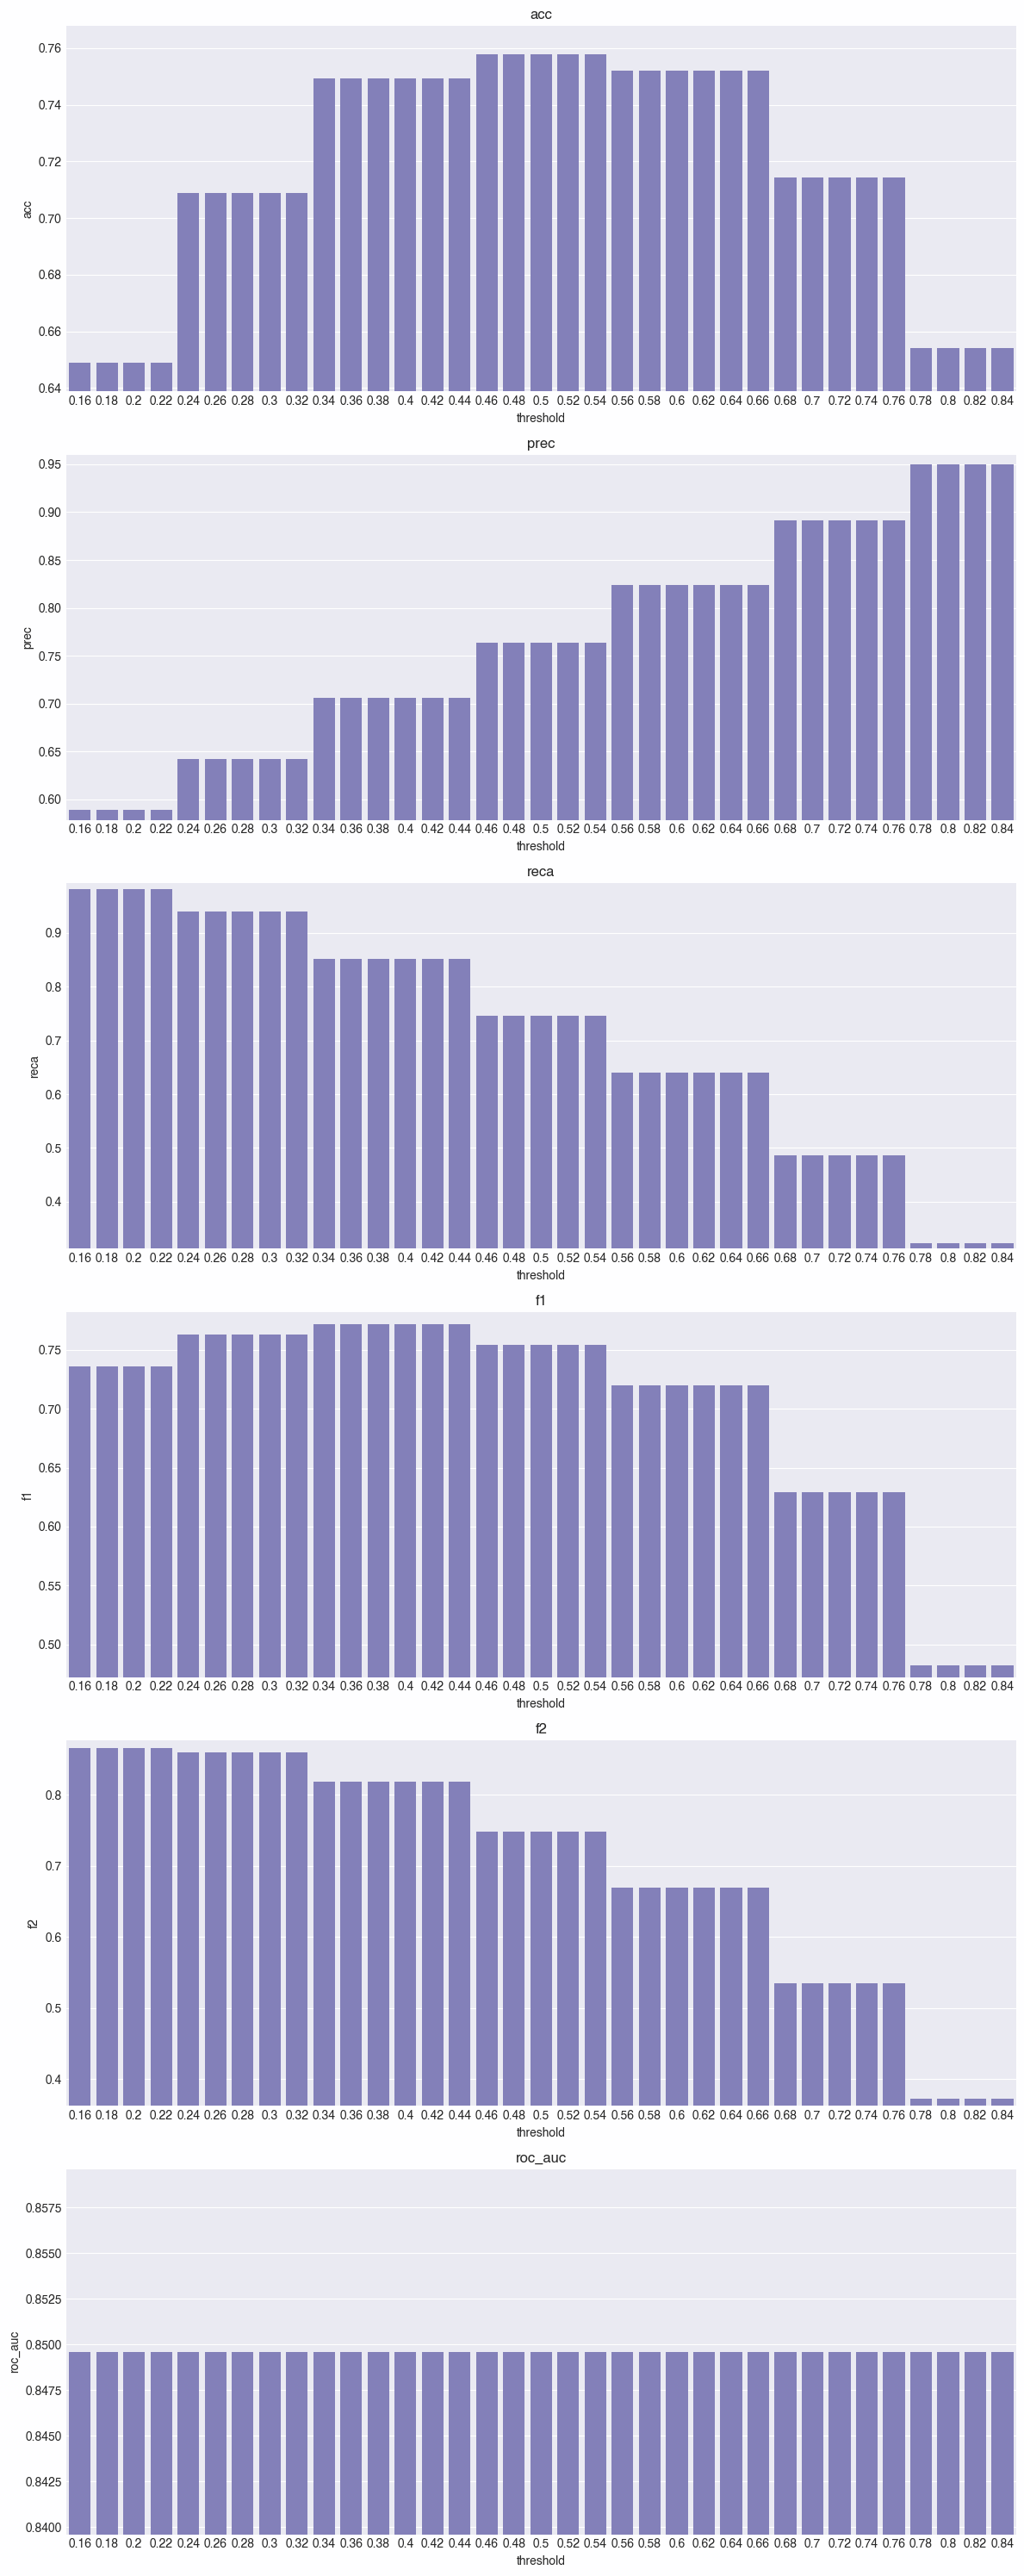

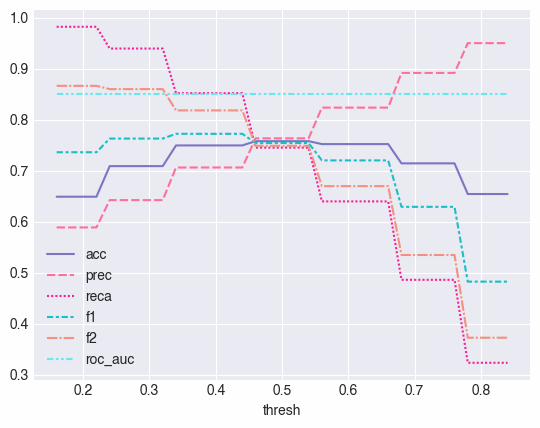

In [8]:
vary_threshold(sKNN, "KNN - calib", thresholds)

-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.815     0.648     0.722      3252
           1      0.706     0.852     0.772      3233

    accuracy                          0.749      6485
   macro avg      0.760     0.750     0.747      6485
weighted avg      0.761     0.749     0.747      6485

f(0.5)-score: 0.731
f(2.0)-score: 0.818

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.729     0.558     0.632       371
           1      0.634     0.787     0.702       361

    accuracy                          0.671       732
   macro avg      0.681     0.672     0.667       732
weighted avg      0.682     0.671     0.667       732

f(0.5)-score: 0.660
f(2.0)-score: 0.751



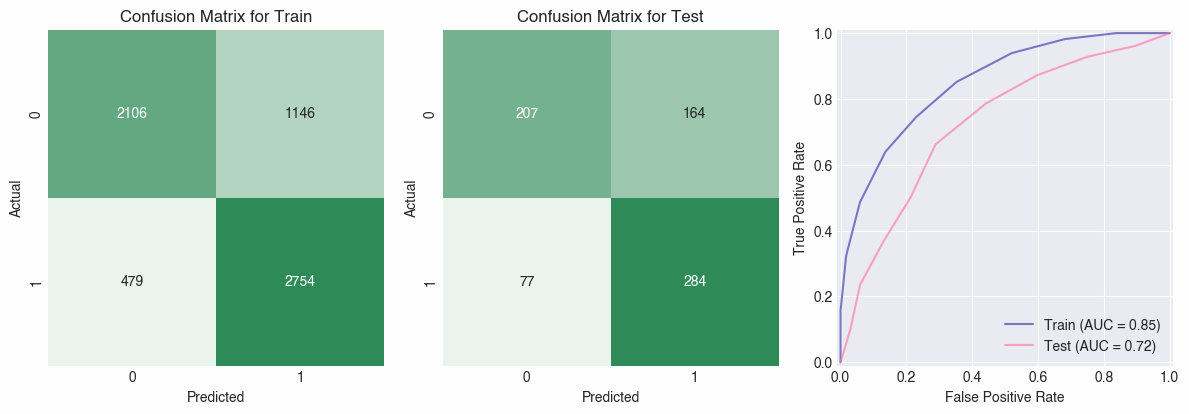

-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.752     0.770     0.761      3252
           1      0.763     0.745     0.754      3233

    accuracy                          0.758      6485
   macro avg      0.758     0.758     0.758      6485
weighted avg      0.758     0.758     0.758      6485

f(0.5)-score: 0.760
f(2.0)-score: 0.749

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.684     0.712     0.697       371
           1      0.691     0.662     0.676       361

    accuracy                          0.687       732
   macro avg      0.687     0.687     0.687       732
weighted avg      0.687     0.687     0.687       732

f(0.5)-score: 0.685
f(2.0)-score: 0.668



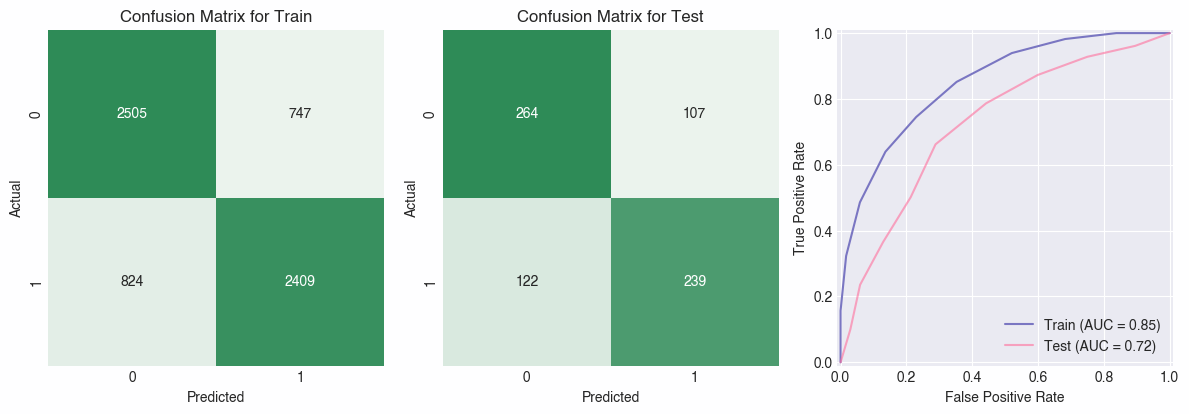

In [9]:
new_threshold(sKNN, new_threshold=0.44)
new_threshold(sKNN, new_threshold=0.5)

----

# LR - calib

/Users/azabicki/miniconda3/envs/EyeTism/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


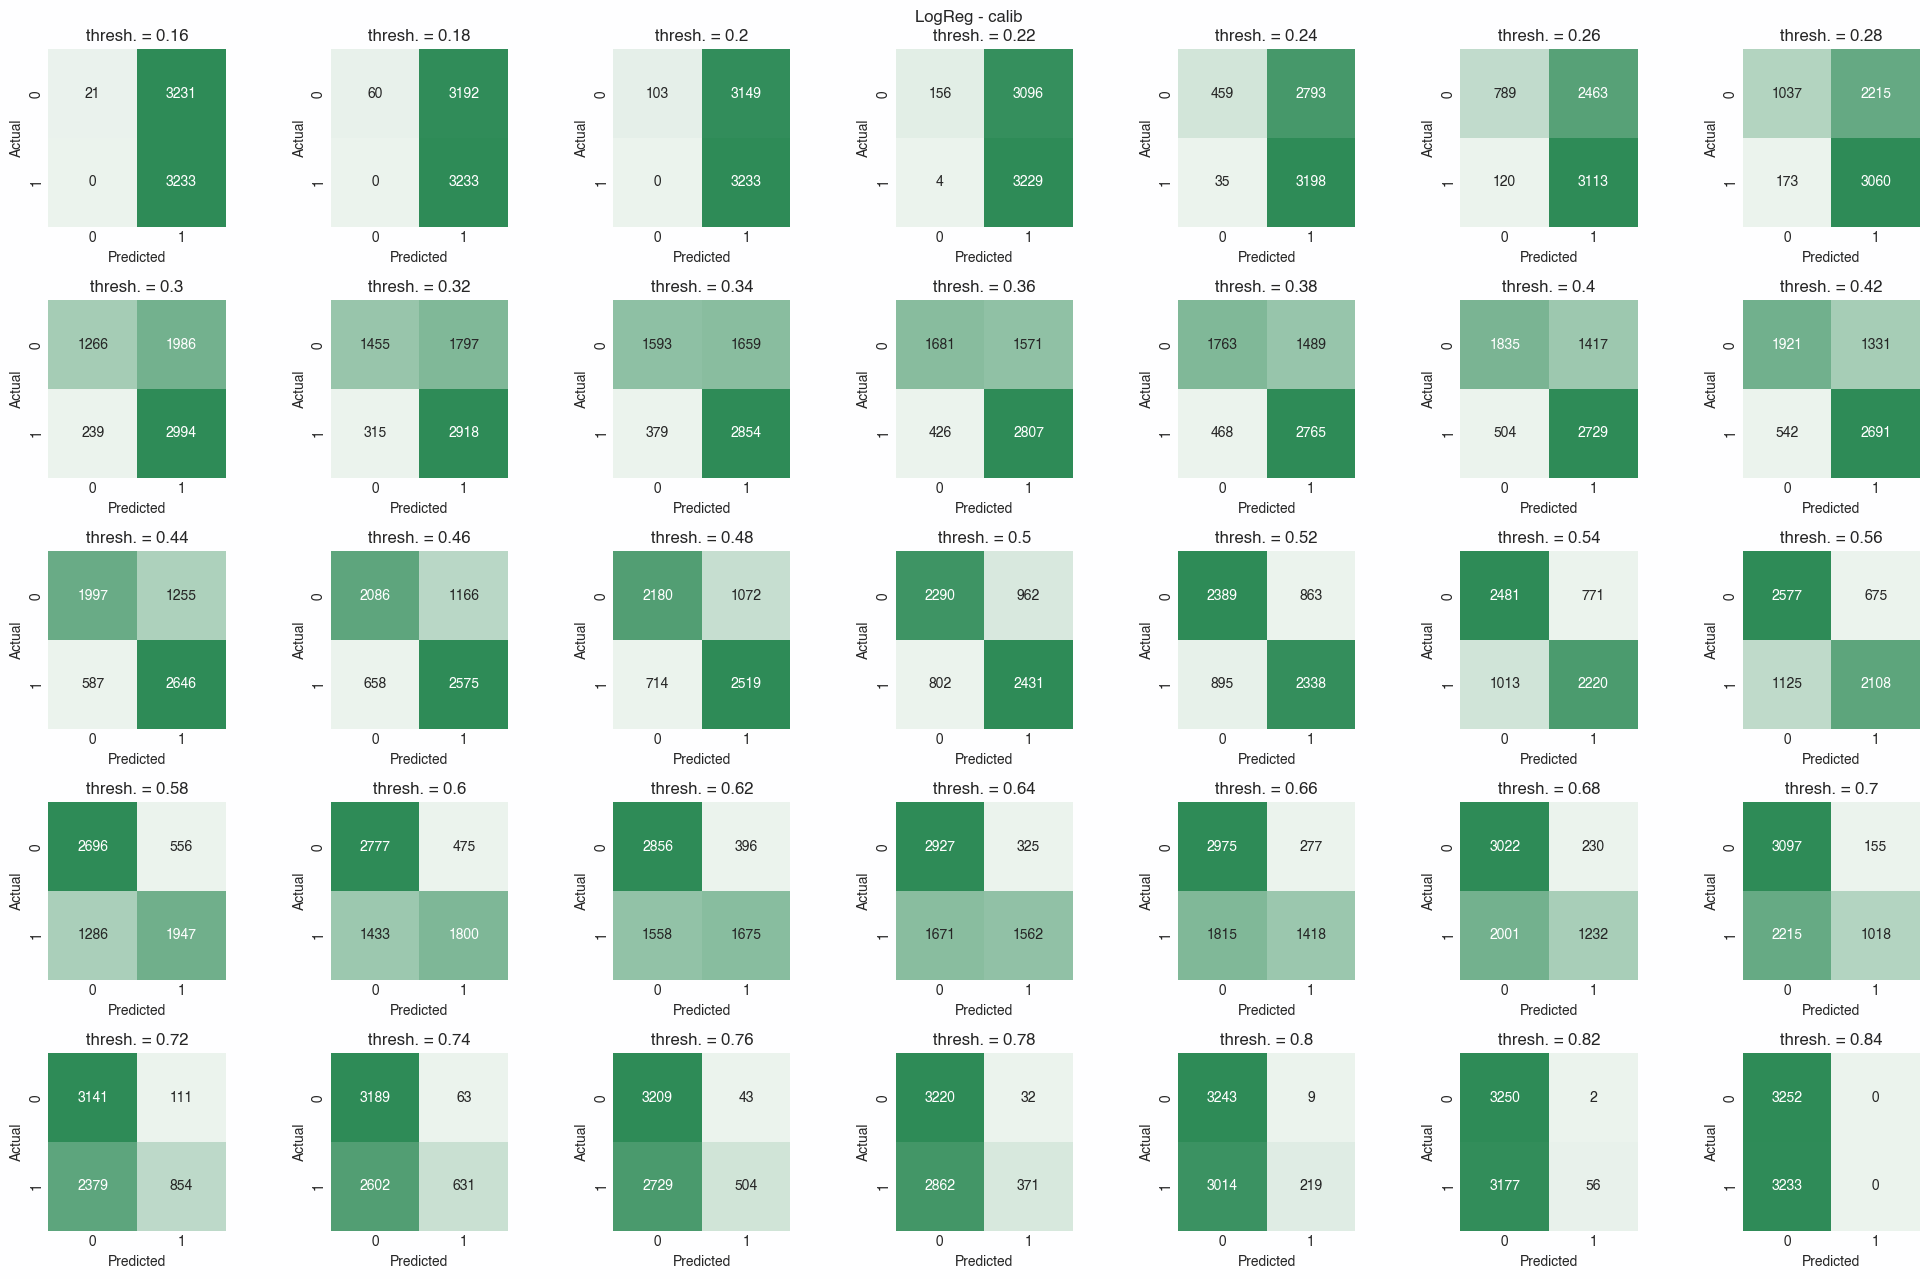

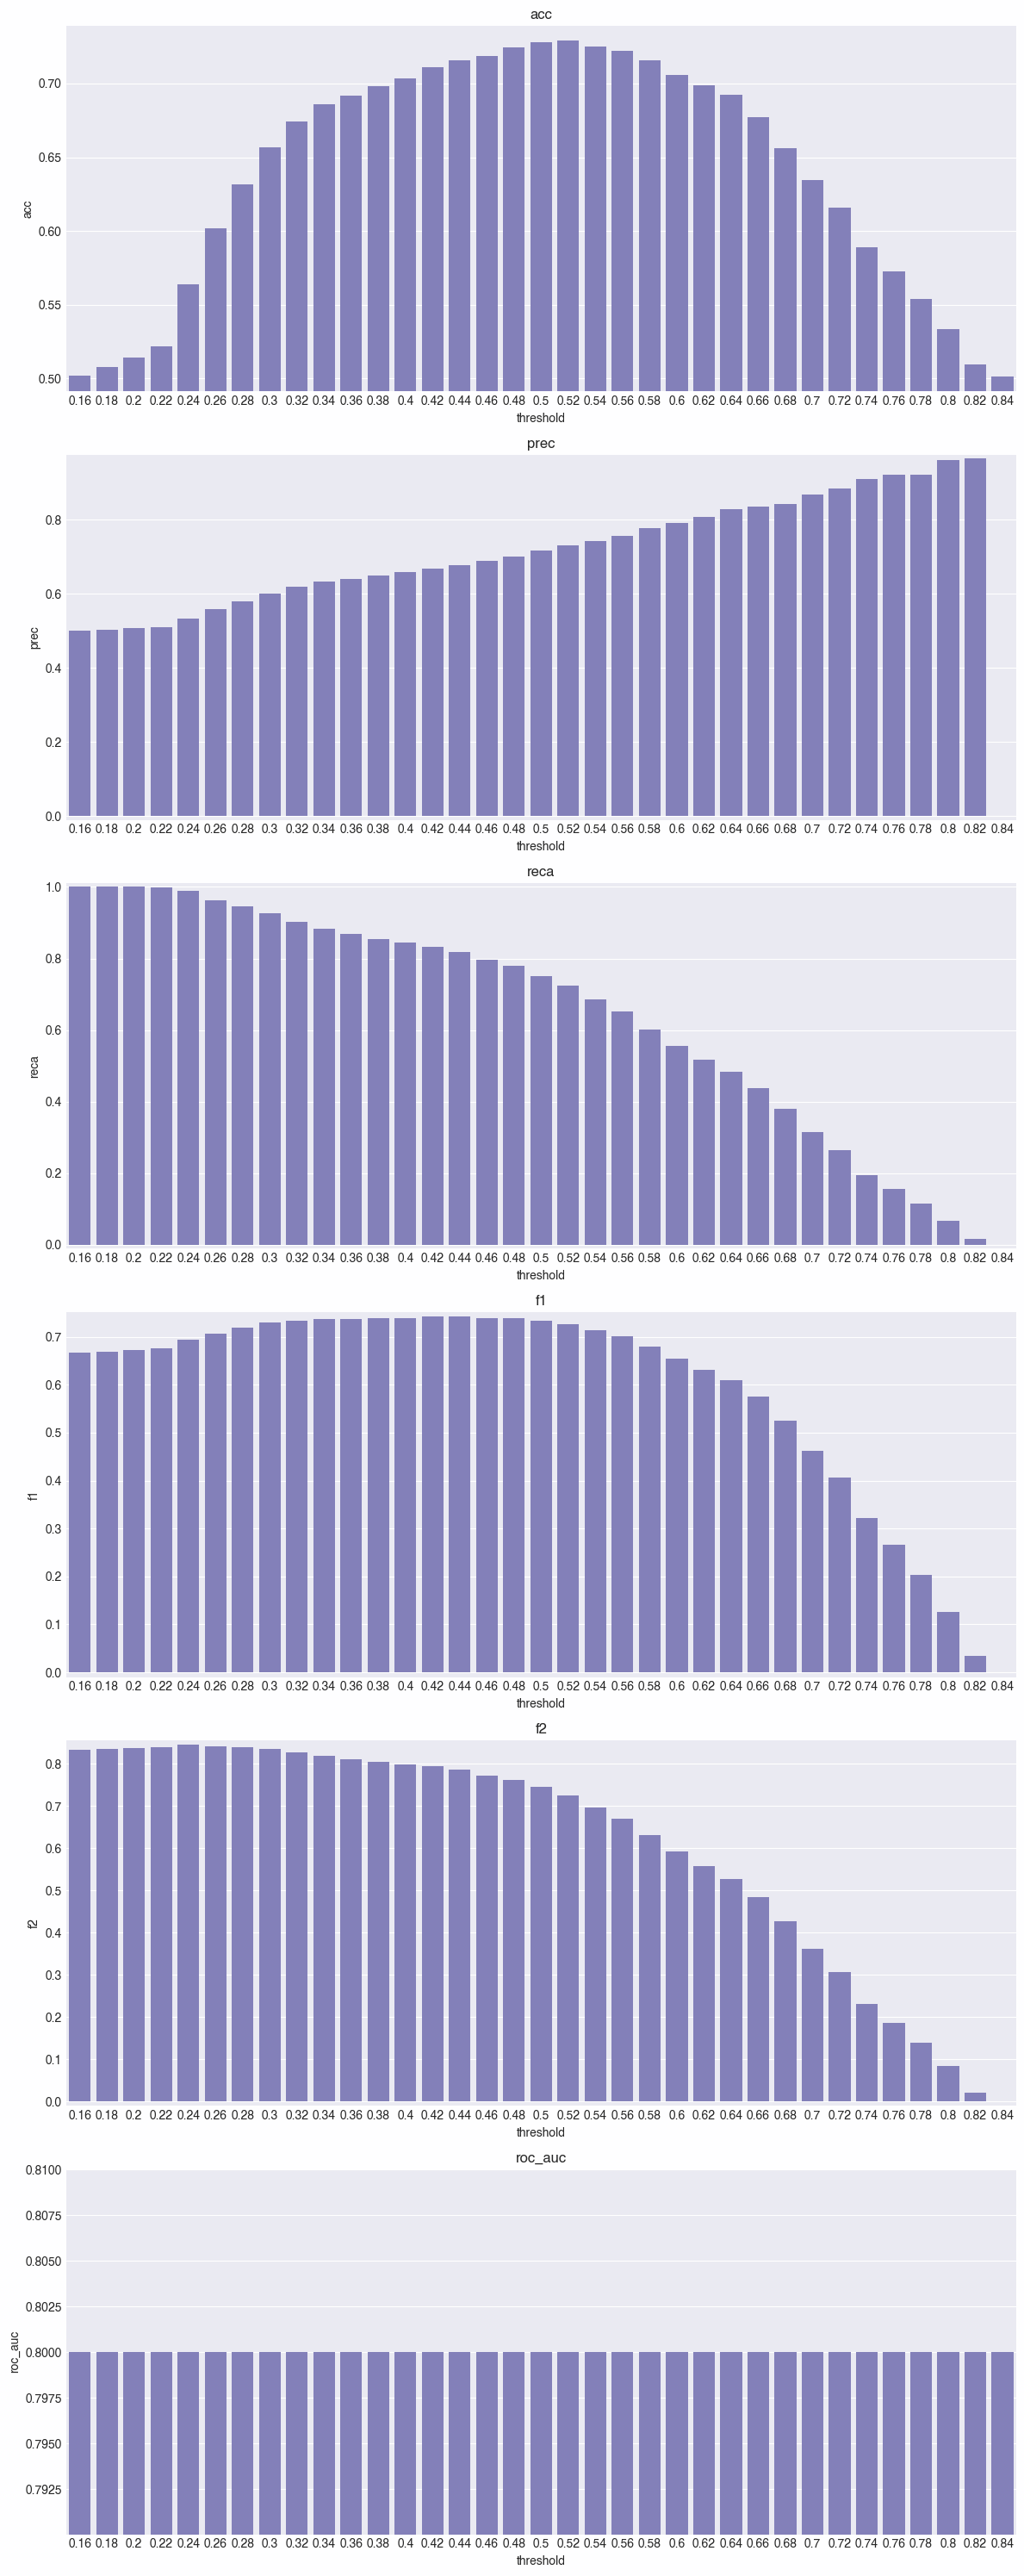

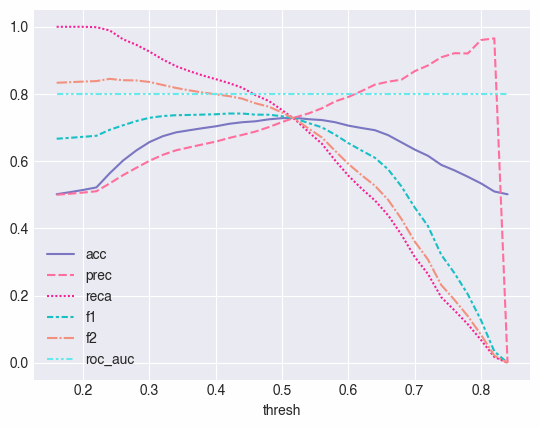

In [10]:
vary_threshold(sLR, "LogReg - calib", thresholds)

-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.773     0.614     0.684      3252
           1      0.678     0.818     0.742      3233

    accuracy                          0.716      6485
   macro avg      0.726     0.716     0.713      6485
weighted avg      0.726     0.716     0.713      6485

f(0.5)-score: 0.702
f(2.0)-score: 0.786

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.750     0.623     0.680       371
           1      0.670     0.787     0.724       361

    accuracy                          0.704       732
   macro avg      0.710     0.705     0.702       732
weighted avg      0.710     0.704     0.702       732

f(0.5)-score: 0.690
f(2.0)-score: 0.760



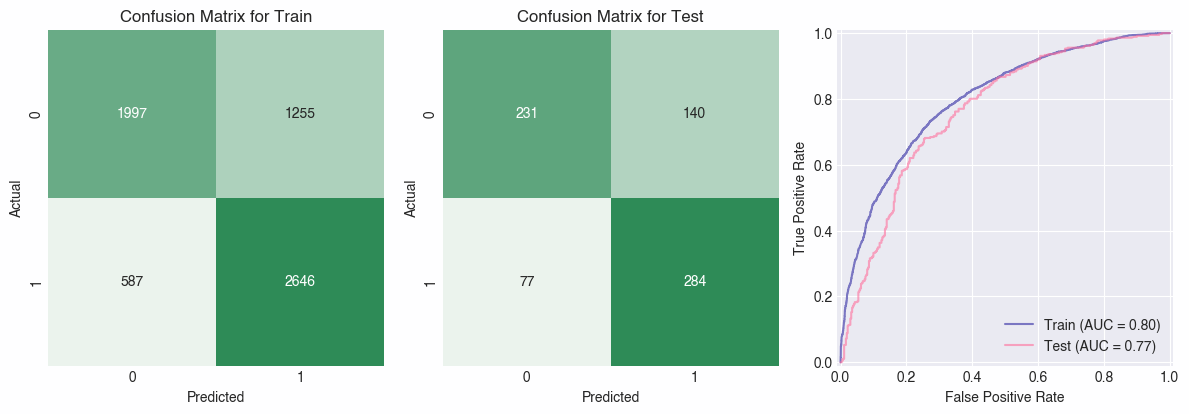

-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.741     0.704     0.722      3252
           1      0.716     0.752     0.734      3233

    accuracy                          0.728      6485
   macro avg      0.729     0.728     0.728      6485
weighted avg      0.729     0.728     0.728      6485

f(0.5)-score: 0.723
f(2.0)-score: 0.745

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.702     0.722     0.712       371
           1      0.706     0.684     0.695       361

    accuracy                          0.704       732
   macro avg      0.704     0.703     0.703       732
weighted avg      0.704     0.704     0.703       732

f(0.5)-score: 0.701
f(2.0)-score: 0.688



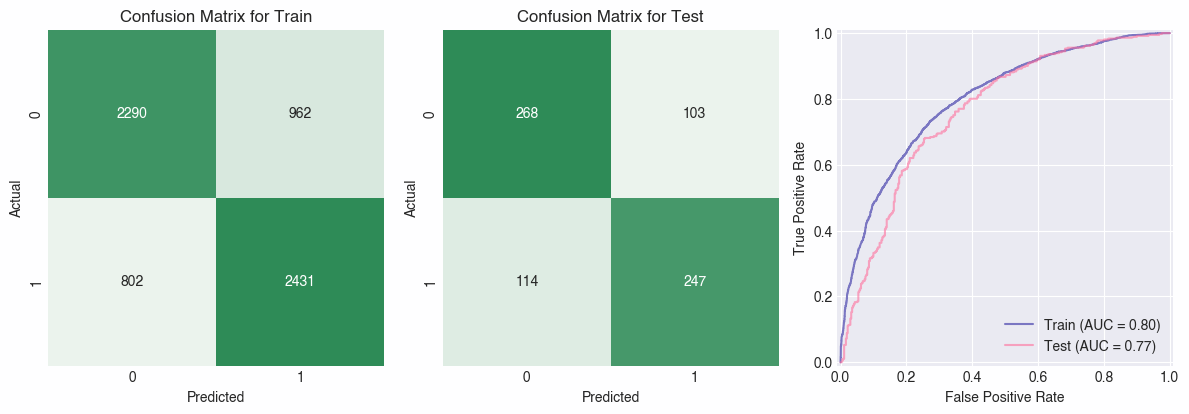

In [11]:
new_threshold(sLR, new_threshold=0.44)
new_threshold(sLR, new_threshold=0.5)

----

# GBM - calib

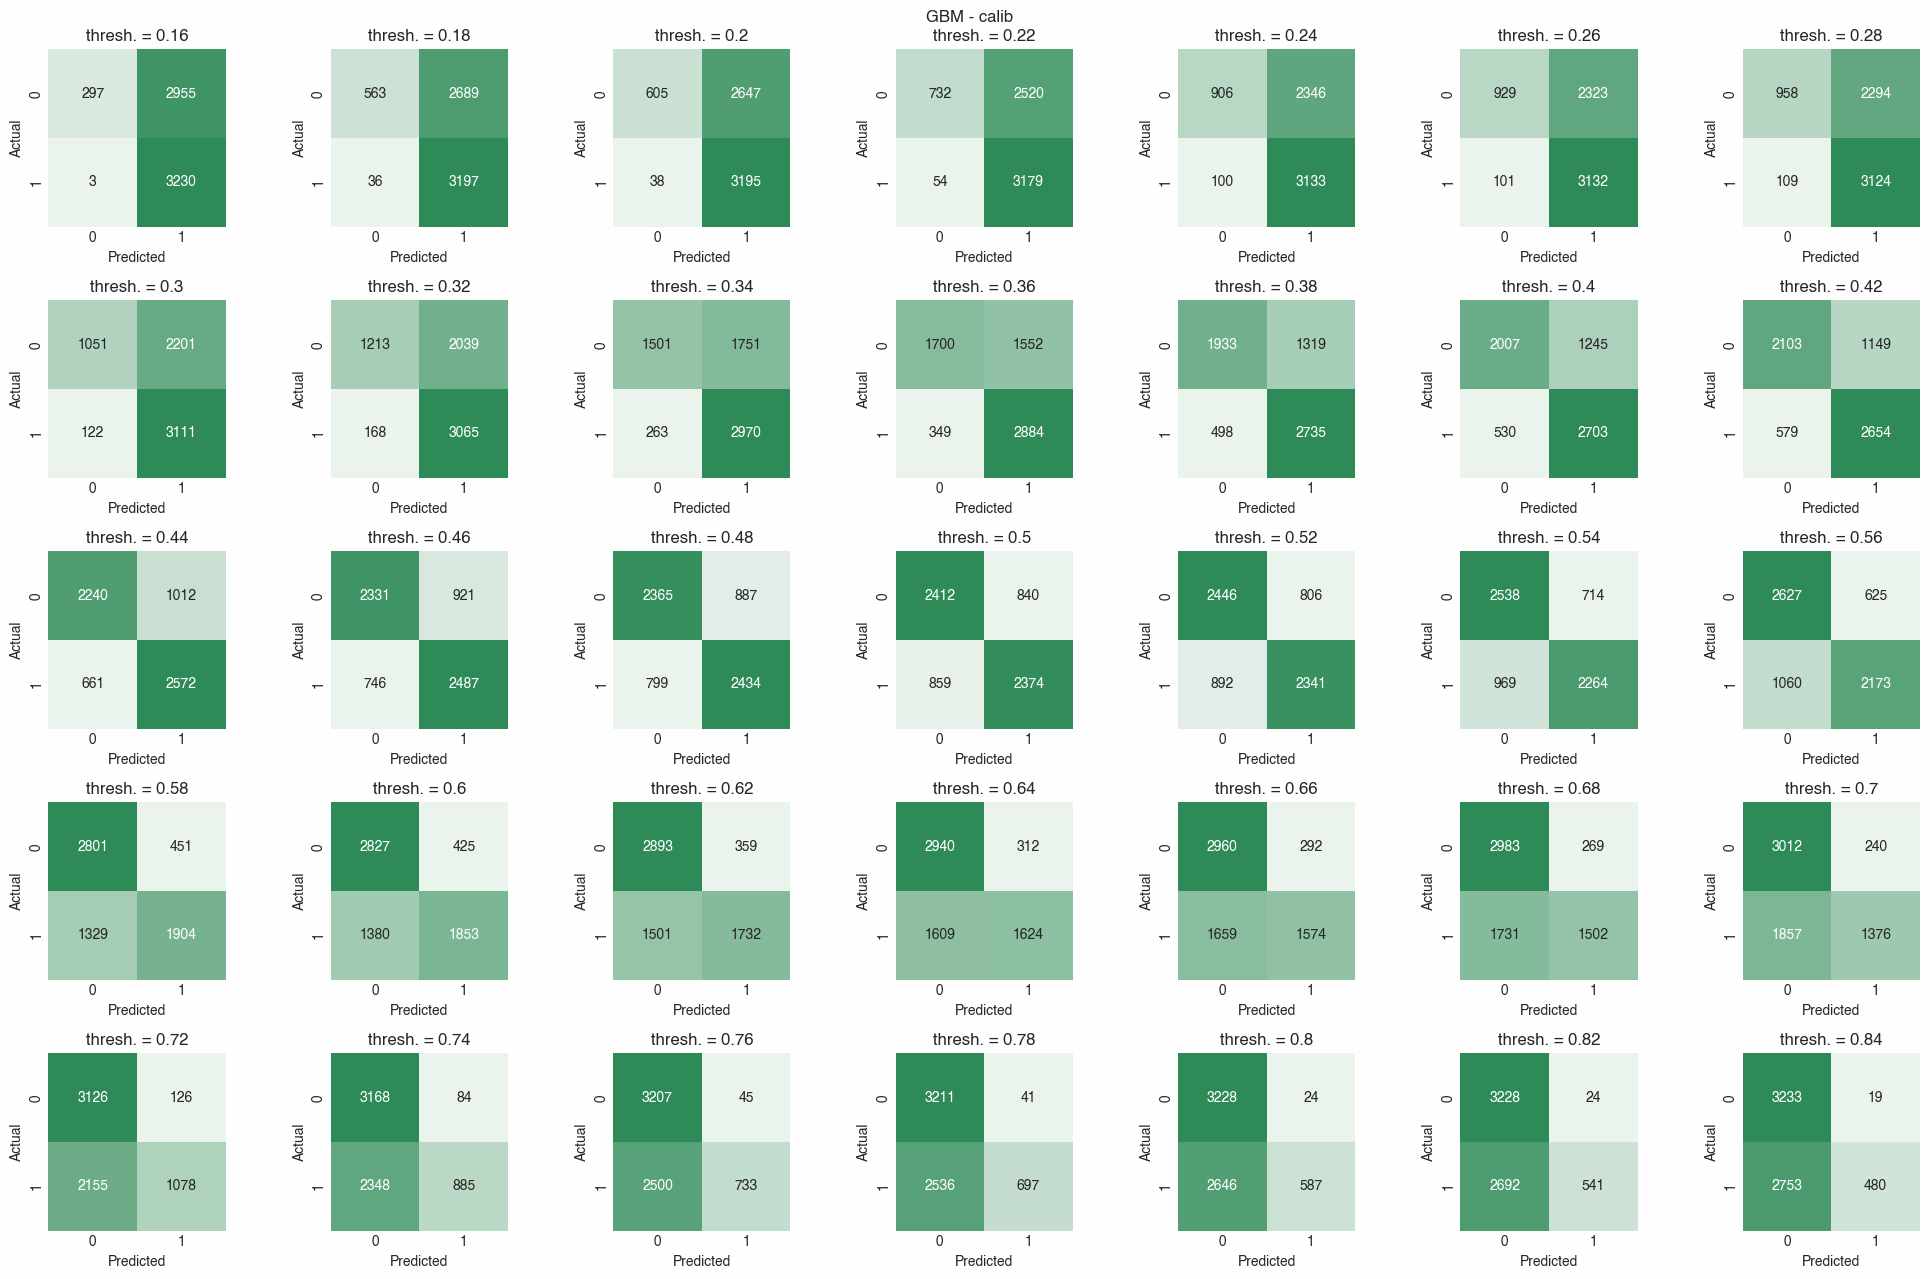

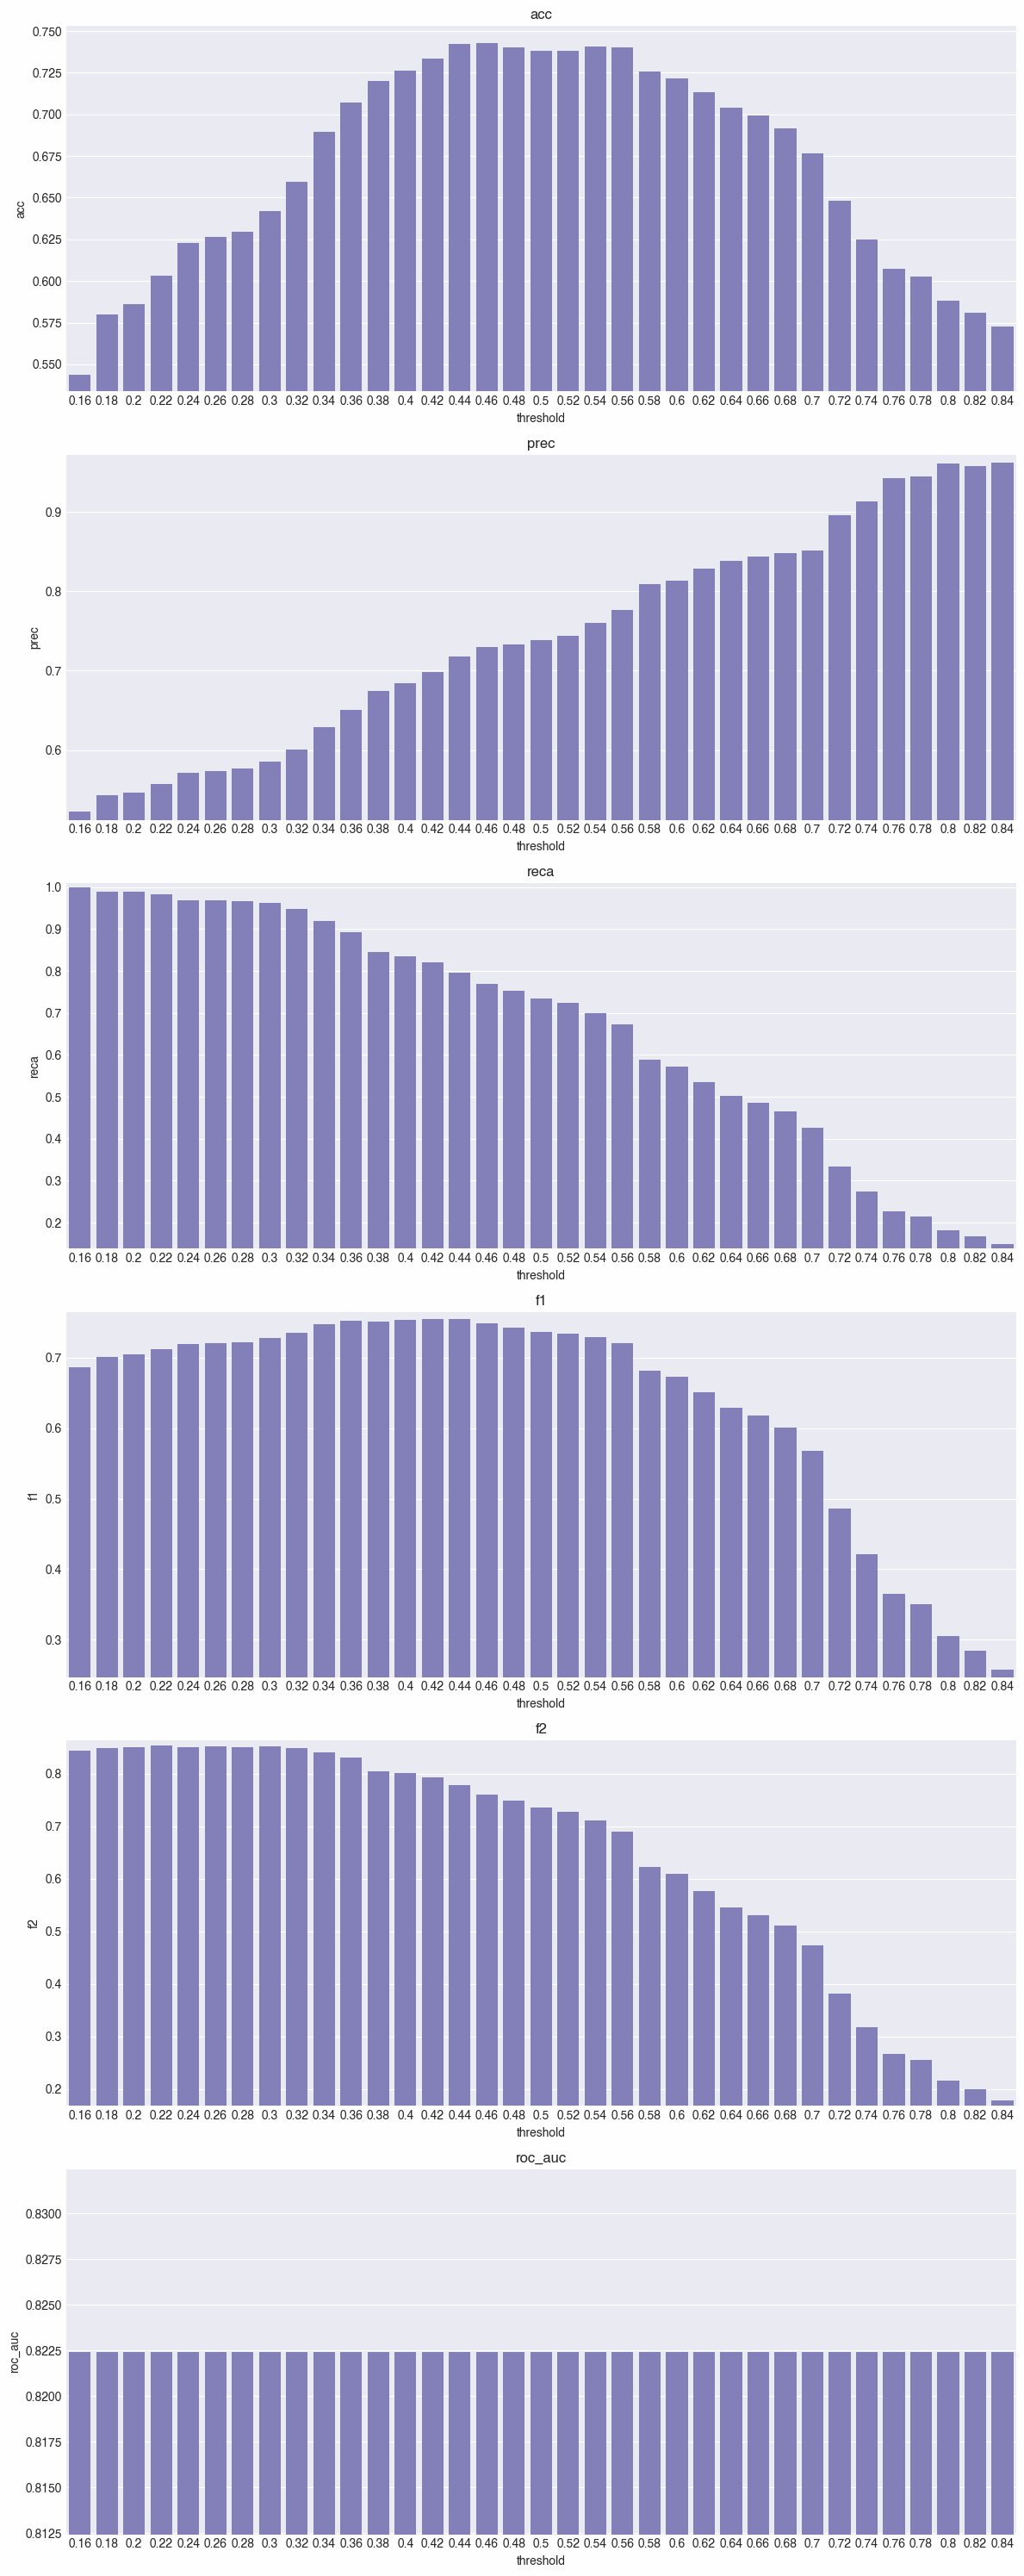

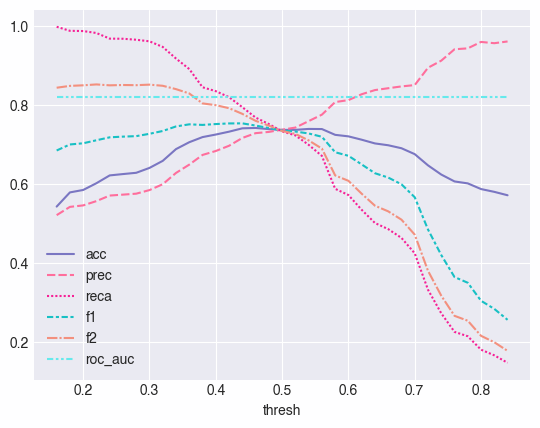

In [12]:
vary_threshold(sGBM, "GBM - calib", thresholds)

-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.791     0.617     0.693      3252
           1      0.685     0.836     0.753      3233

    accuracy                          0.726      6485
   macro avg      0.738     0.727     0.723      6485
weighted avg      0.738     0.726     0.723      6485

f(0.5)-score: 0.710
f(2.0)-score: 0.801

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.740     0.590     0.657       371
           1      0.651     0.787     0.713       361

    accuracy                          0.687       732
   macro avg      0.696     0.689     0.685       732
weighted avg      0.696     0.687     0.684       732

f(0.5)-score: 0.675
f(2.0)-score: 0.755



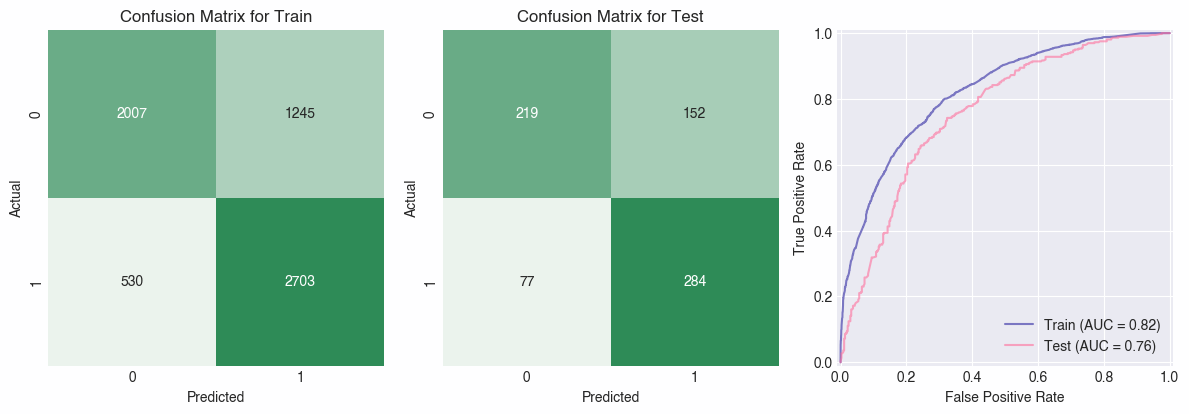

-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.737     0.742     0.740      3252
           1      0.739     0.734     0.736      3233

    accuracy                          0.738      6485
   macro avg      0.738     0.738     0.738      6485
weighted avg      0.738     0.738     0.738      6485

f(0.5)-score: 0.738
f(2.0)-score: 0.735

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.695     0.755     0.724       371
           1      0.723     0.659     0.690       361

    accuracy                          0.708       732
   macro avg      0.709     0.707     0.707       732
weighted avg      0.709     0.708     0.707       732

f(0.5)-score: 0.710
f(2.0)-score: 0.671



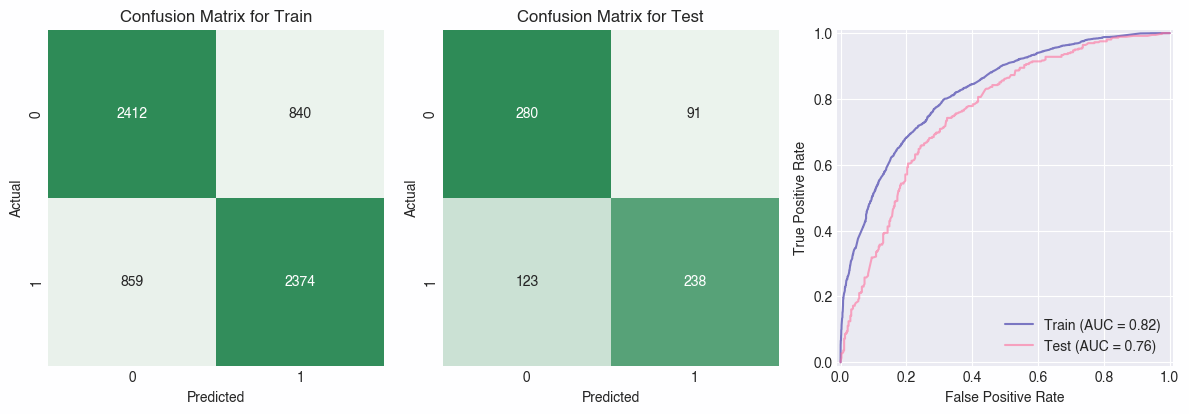

In [13]:
new_threshold(sGBM, new_threshold=0.4)
new_threshold(sGBM, new_threshold=0.5)

----

# NB - calib

In [14]:
thresholds = [i / 100 for i in list(range(2, 52, 2))]

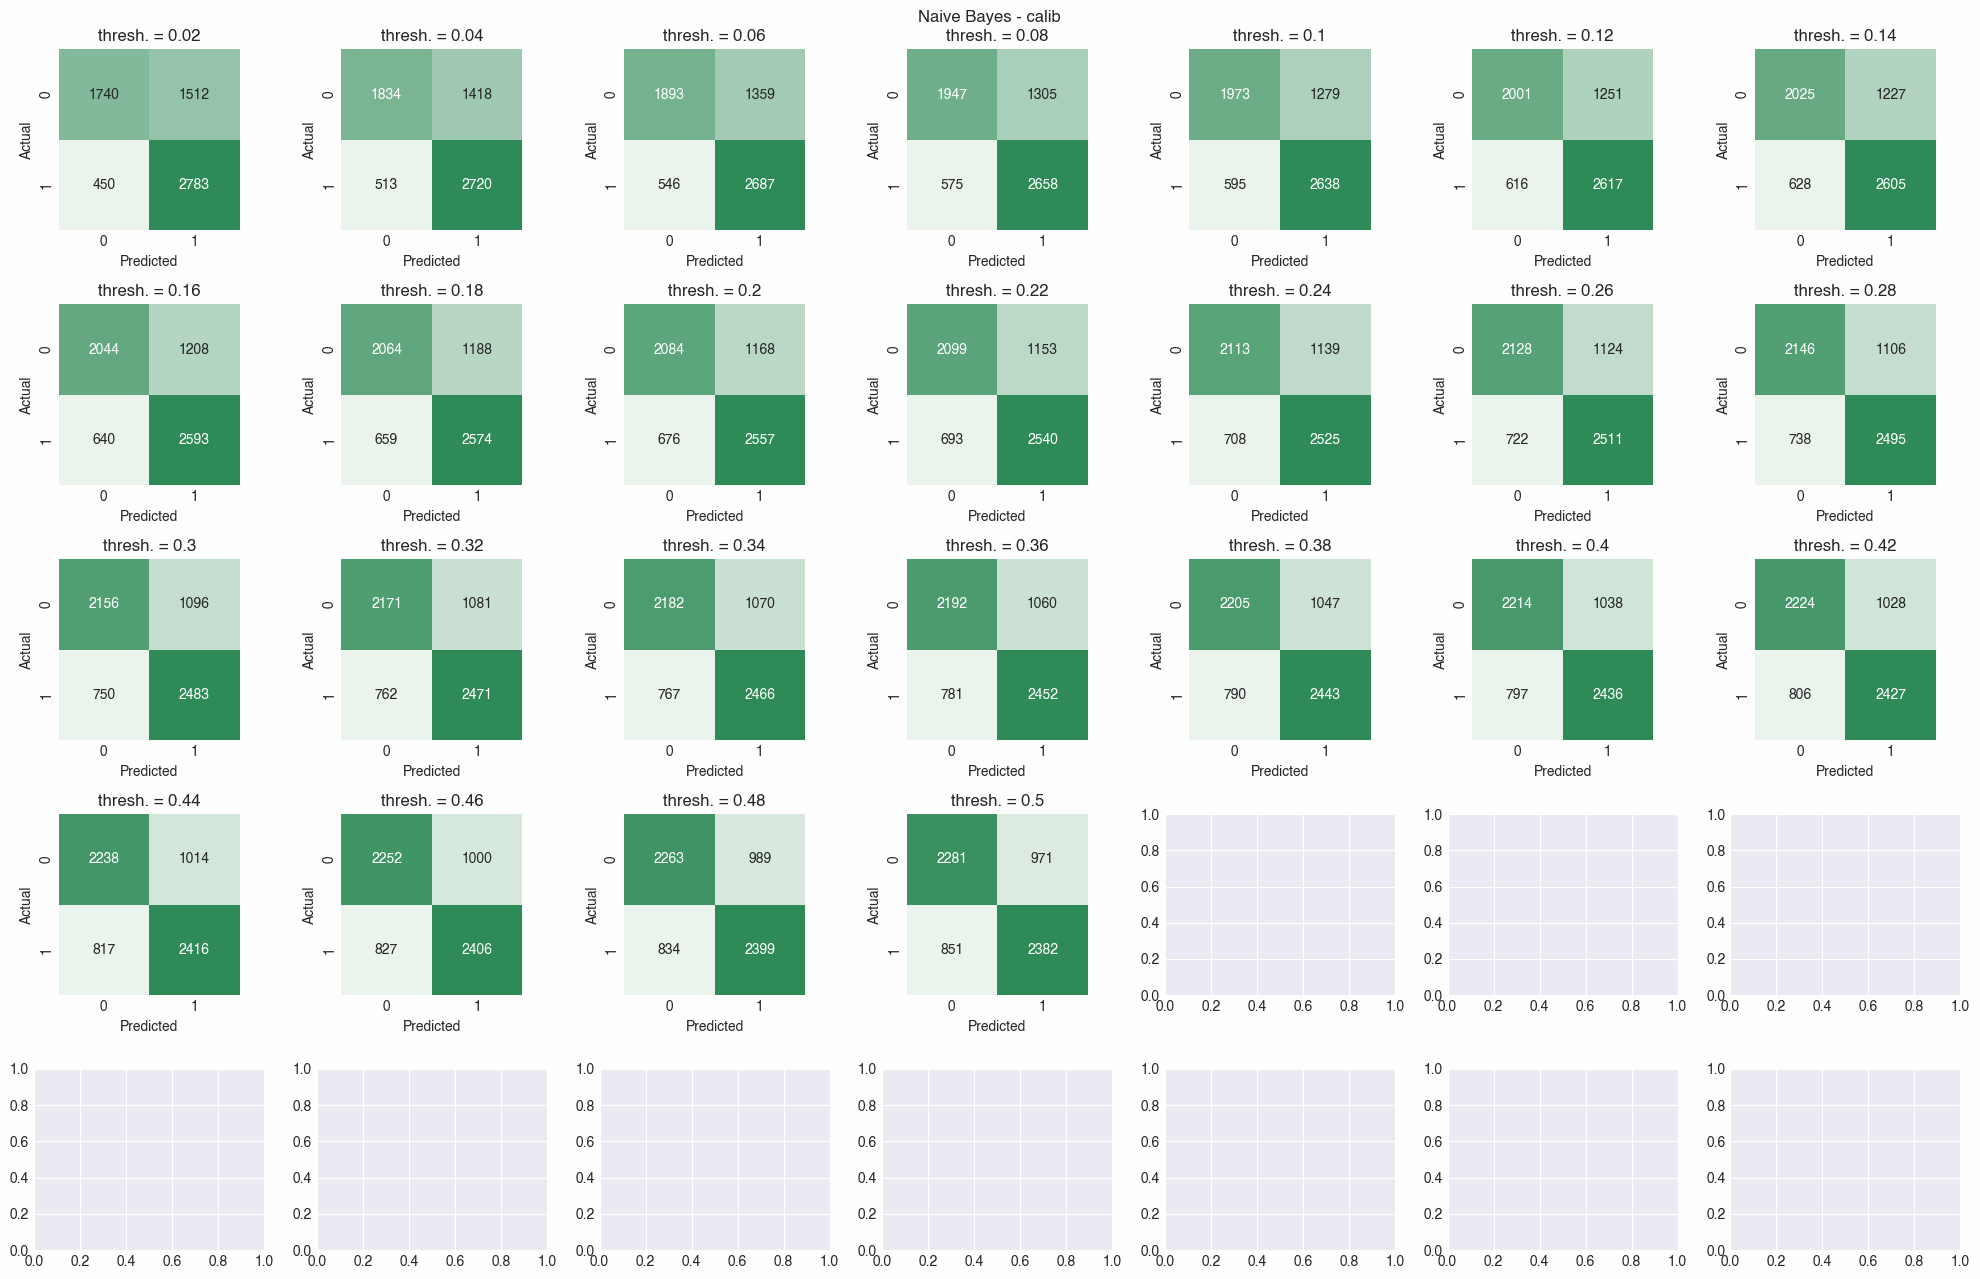

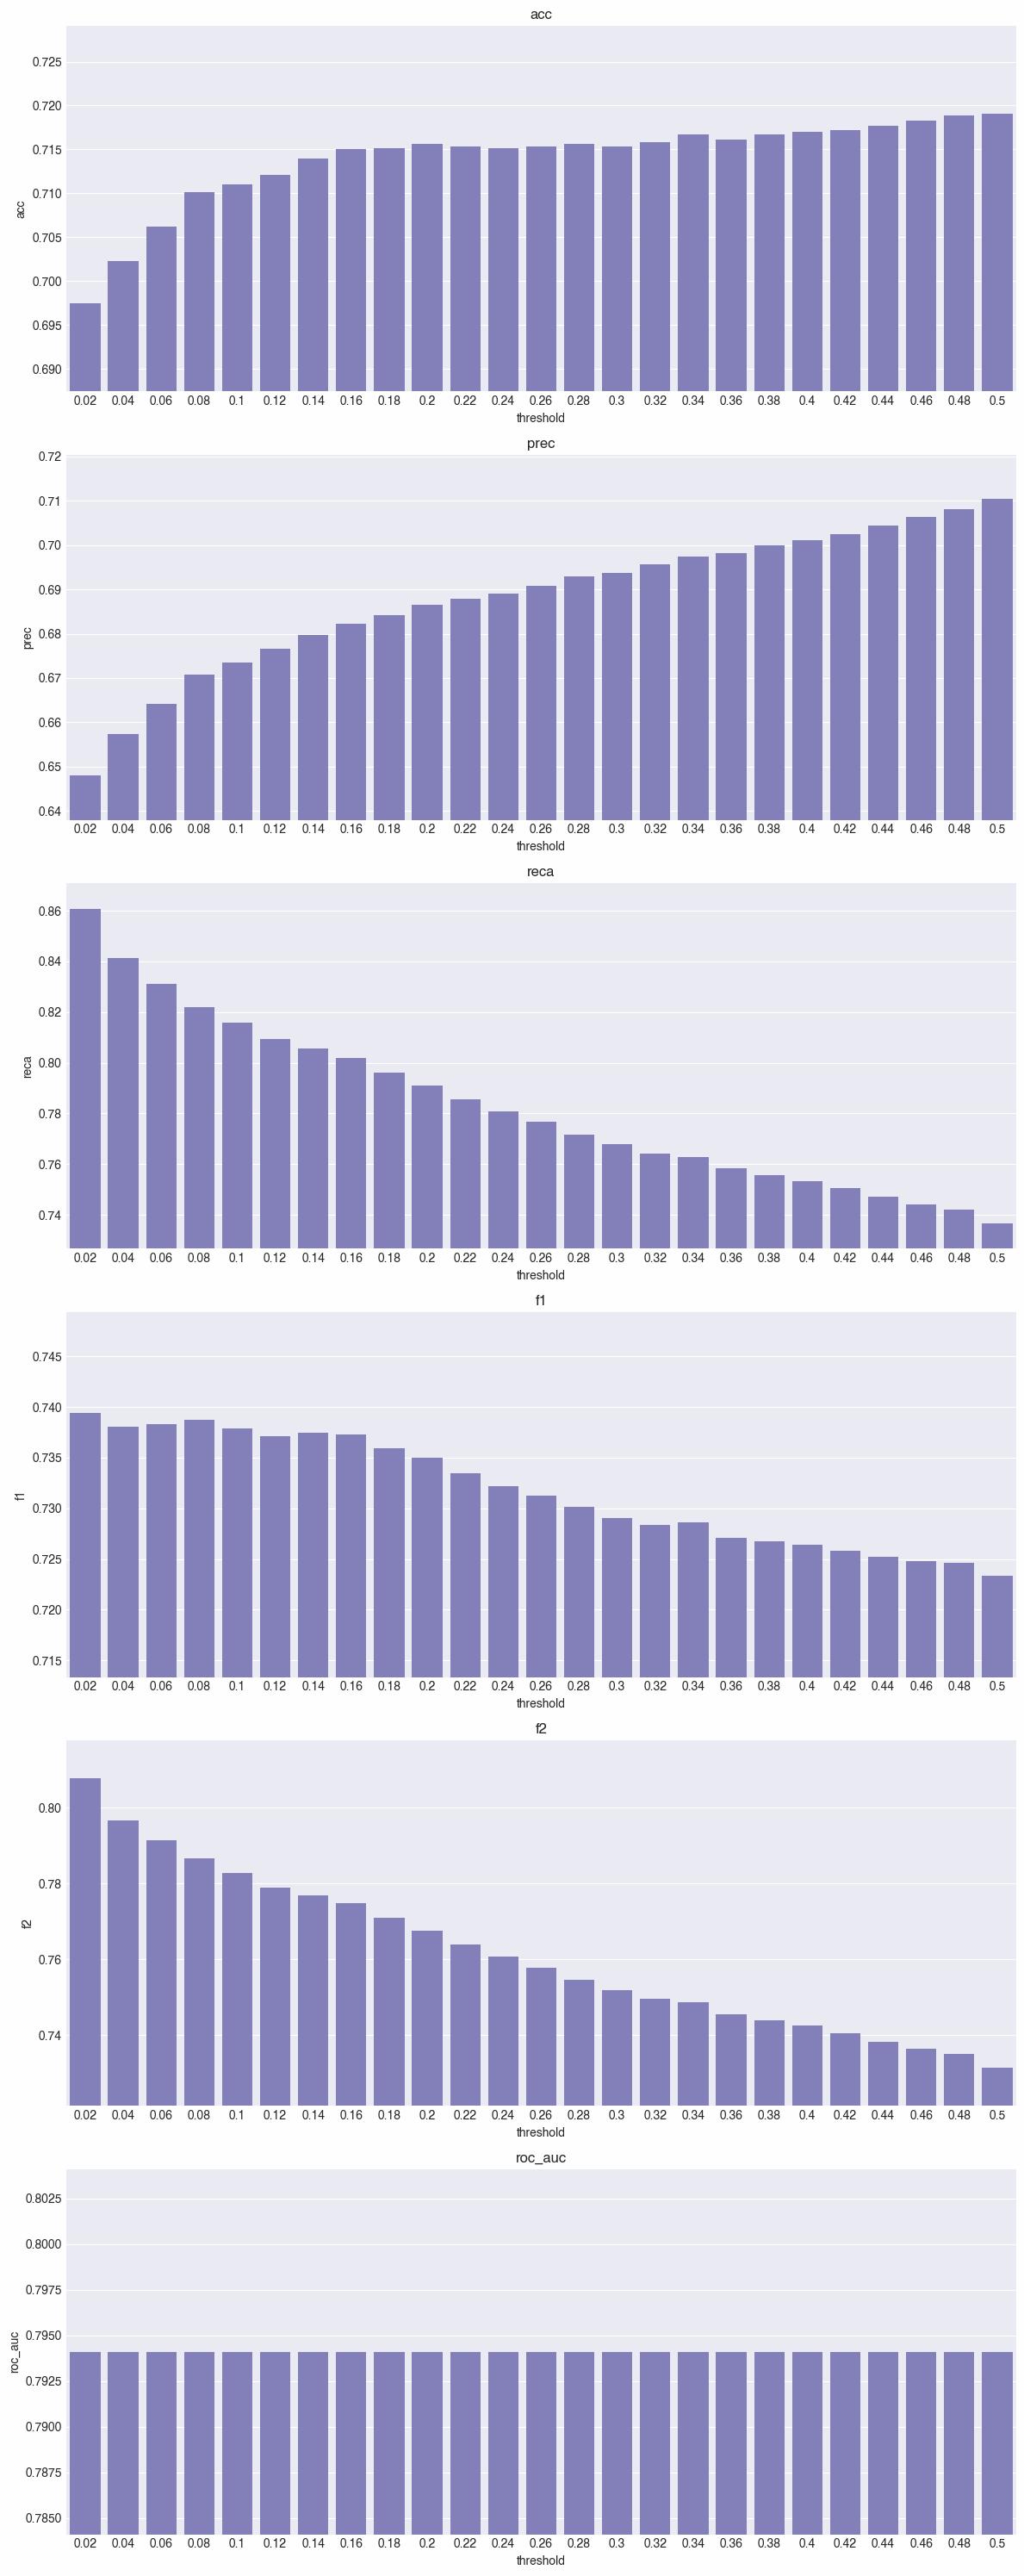

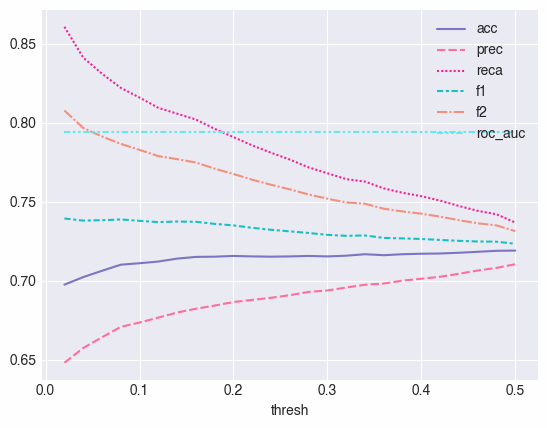

In [15]:
vary_threshold(sNB, "Naive Bayes - calib", thresholds)

-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.763     0.623     0.686      3252
           1      0.680     0.806     0.737      3233

    accuracy                          0.714      6485
   macro avg      0.722     0.714     0.712      6485
weighted avg      0.722     0.714     0.712      6485

f(0.5)-score: 0.702
f(2.0)-score: 0.777

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.738     0.647     0.690       371
           1      0.678     0.765     0.719       361

    accuracy                          0.705       732
   macro avg      0.708     0.706     0.704       732
weighted avg      0.709     0.705     0.704       732

f(0.5)-score: 0.694
f(2.0)-score: 0.746



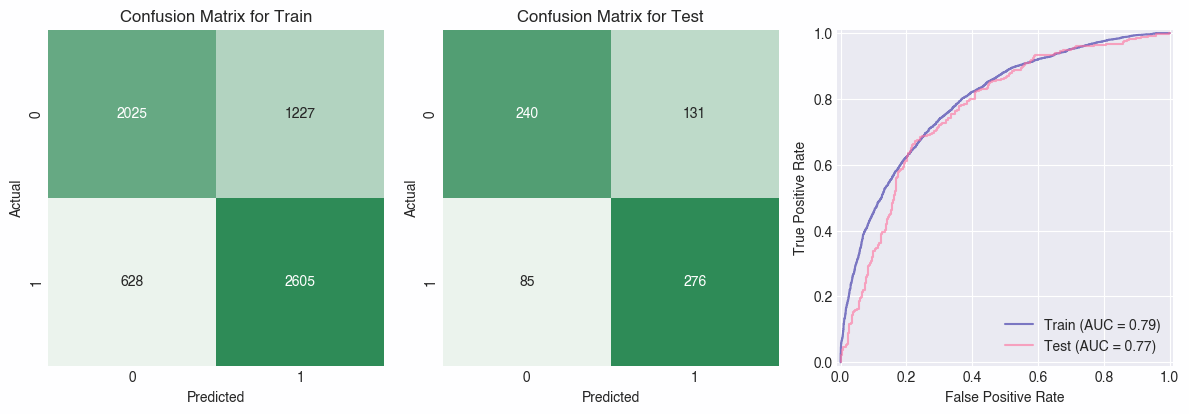

-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.728     0.701     0.715      3252
           1      0.710     0.737     0.723      3233

    accuracy                          0.719      6485
   macro avg      0.719     0.719     0.719      6485
weighted avg      0.719     0.719     0.719      6485

f(0.5)-score: 0.716
f(2.0)-score: 0.731

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.710     0.747     0.728       371
           1      0.725     0.687     0.706       361

    accuracy                          0.717       732
   macro avg      0.718     0.717     0.717       732
weighted avg      0.718     0.717     0.717       732

f(0.5)-score: 0.717
f(2.0)-score: 0.694



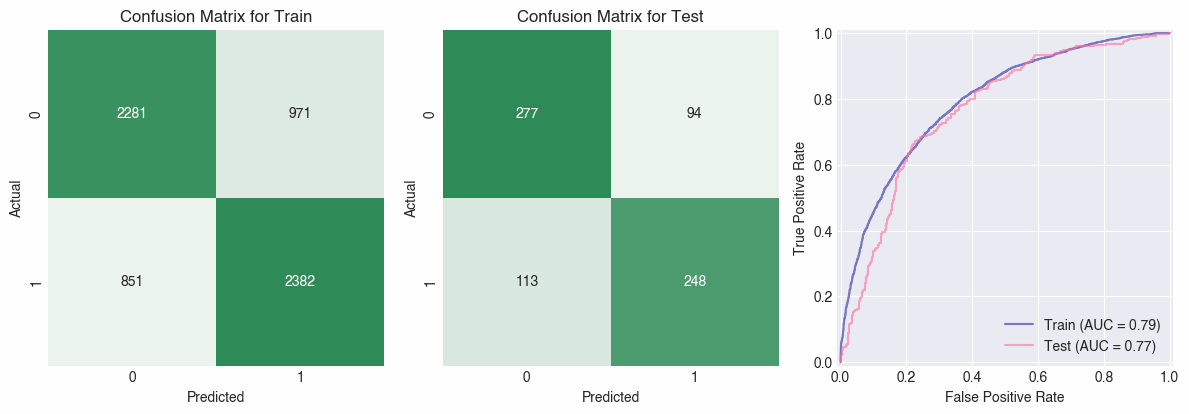

In [16]:
new_threshold(sNB, new_threshold=0.14)
new_threshold(sNB, new_threshold=0.5)